<div align = "center"><img src = "https://upload.wikimedia.org/wikipedia/en/thumb/3/3b/Stony_Brook_U_logo_vertical.svg/1024px-Stony_Brook_U_logo_vertical.svg.png" width ="300"></div>

# <div align="center"> **AMS 512 Notebook Project: Mathematica to Python** </div>

## <div align="center"> **Extreme Events** </div>

### <div align = "center"> **Authors:** *Ainasse, El Mehdi, de Oliveira Gomes, Marlon, and Lize, Matheus Loss* </div>

## **Disclaimer**

All present contents are mainly excerpts from the original notebook by Prof. Robert J. Frey. In particular, textual contents are directly quoted and/or copy-pasted while the coding components have been re-adapted from Mathematica to Python.

# **Initial set-up**

In [13]:
import pandas as pd
import numpy as np
import math
import os
import scipy.stats as stats
import sys
import random
import matplotlib.pyplot as plt
import seaborn as sns

# **A look at real data**

### **Downloading and processing the data**

The file 'mxSP500Index.csv' contains monthly index data for the S & P 500 Total Return Index from December 1899 to December 2015. The term 'total return' in this instance includes the reinvestment of dividends back into the index so that ir properly represents the total wealth from investing in the infex. Although this index did not exist over this period, the file a reconstruction of it by Global Financial Data. 

In [2]:
data = pd.read_csv("mxSP500Index.csv", 
                   header = None,
                   names = ['date', 'return'],
                   index_col = 'date')
data.index = pd.to_datetime(data.index,format = '{%Y, %m, %d}')
data

,return
date,
1899-12-31,0.099705
1900-01-31,0.101342
1900-02-28,0.103484
1900-03-31,0.104631
1900-04-30,0.106294
...,...
2015-08-31,3660.750000
2015-09-30,3570.170000
2015-10-30,3871.330000


Plot time series data

Log plot of time series data.

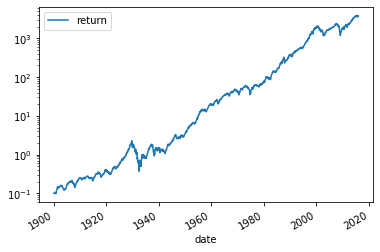

In [3]:
data.plot(logy = True)

In [ ]:
We can compute the log returns

In [4]:
def get_log_return(df):
    log_returns = pd.Series(np.log(df['return']).diff(),name='log returns')
    return pd.concat([df,log_returns], axis=1)

In [5]:
mxSP500LogReturn = get_log_return(data).iloc[1:]
mxSP500LogReturn

,return,log returns
date,,
1900-01-31,0.101342,0.016280
1900-02-28,0.103484,0.020918
1900-03-31,0.104631,0.011023
1900-04-30,0.106294,0.015769
1900-05-31,0.101591,-0.045255
...,...,...
2015-08-31,3660.750000,-0.062231
2015-09-30,3570.170000,-0.025055
2015-10-30,3871.330000,0.080985


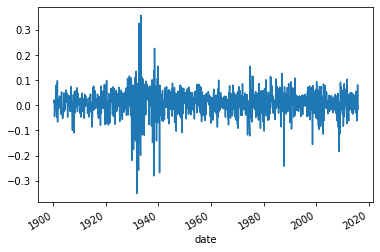

In [6]:
mxSP500LogReturn['log returns'].plot()

In [10]:
#mxSP500LogReturn['log returns'].to_csv('mxSP500LogReturn.csv')

# **Characterizing the return distribution**

### **Fitting candidate distributions**

In [23]:
def FD_histogram(df):
    
    q1 = df["log returns"].quantile(.75)
    q2 = df["log returns"].quantile(.25)
    n = len(df["log returns"])
    bin_width = 2*(q1 - q2)*(n**(-1/3))
    #num_of_bins = math.floor((df["log returns"].max()-df["log returns"].min())/bin_width)
    num_of_bins = math.ceil((df["log returns"].max()-df["log returns"].min())/bin_width)
   
    return df["log returns"].hist(bins=num_of_bins,density =True,figsize = (15,10))

In [7]:
q1 = mxSP500LogReturn["log returns"].quantile(.75)
q2 = mxSP500LogReturn["log returns"].quantile(.25)
n = len(mxSP500LogReturn["log returns"])
bin_width = 2*(q1 - q2)*(n**(-1/3))
bin_width

0.009662337378975185

The historgram has an option for a binning strategy, such as 'auto', 'sturges', 'fd', 'doane', 'scott', 'rice' or 'sqrt'. 
https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist.html 


In [ ]:
##################################################################################################################################################################### Fitting Candidate Distributions
####################################################################################################################################################################

Statistical functions (scipy.stats) documentation:  
https://docs.scipy.org/doc/scipy/reference/stats.html

First we chose a distribution ( normal , student-t or non-central student t) to fit the data, using: 

$$stats.*distribution*.fit(data).$$
Ex: Normal distribution ->   stats.norm.fit (data)

Then we generate the pdf to plot the model vs the histogram. 
We use 

$$ stats.*distribution*.pdf(x, *Fit-Parameters* ), $$

where x is x-axis from the histogram plot (bins) and Fit-Parameters were computed in the previews step ( stats.*distribution*.fit).


In [9]:
# X -axis from the histogram:
_, x_bins = np.histogram(mxSP500LogReturn['log returns'],bins='fd',density=True)

In [252]:
# The last 4 objects are: mean , variance , skew, kurtosis
ObservedStats = np.array(stats.describe(mxSP500LogReturn['log returns']))[2:]
ObservedStats

array([0.0075818688726212655, 0.002589376151307557, -0.47815165788155284,
       8.205243503713021], dtype=object)

In [ ]:
# Normal Distribution: 

In [107]:
NormParameter= stats.norm.fit(mxSP500LogReturn['log returns'])
NormParameter

(0.0075818688726212655, 0.05086763182310351)

In [228]:
NormPDF = stats.norm.pdf(x_bins,NormParameter[0],NormParameter[1])

In [229]:
NormStats = np.array(stats.norm.stats(NormParameter[0],NormParameter[1],moments='mvsk'))
NormStats

array([0.00758187, 0.00258752, 0.        , 0.        ])

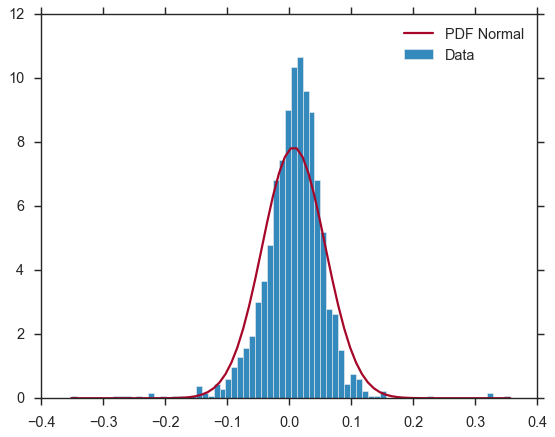

In [227]:
plt.figure(num=None, figsize=(8, 6))
plt.hist(mxSP500LogReturn['log returns'],bins='fd',density=True,label='Data')
plt.plot(x_bins,NormPDF,label='PDF Normal')
plt.legend()


In [26]:
# Student t distribution 
sTParameter= stats.t.fit(mxSP500LogReturn['log returns'])
sTParameter

(3.832627435543939, 0.010398545919483748, 0.034762484815485176)

In [197]:
sTPDF = stats.t.pdf(x_bins,sTParameter[0],sTParameter[1],sTParameter[2])

In [38]:
sTPDF = stats.t.pdf(x_bins,*sTParameter)

In [39]:
sTPDF

array([3.08261060e-03, 3.49318997e-03, 3.97111908e-03, 4.52960382e-03,
       5.18487866e-03, 5.95700549e-03, 6.87091169e-03, 7.95774775e-03,
       9.25667480e-03, 1.08172349e-02, 1.27025170e-02, 1.49934186e-02,
       1.77944271e-02, 2.12415282e-02, 2.55131169e-02, 3.08451831e-02,
       3.75526390e-02, 4.60595504e-02, 5.69423886e-02, 7.09924915e-02,
       8.93070837e-02, 1.13423059e-01, 1.45515113e-01, 1.88690962e-01,
       2.47432711e-01, 3.28256185e-01, 4.40688257e-01, 5.98687536e-01,
       8.22627204e-01, 1.14183982e+00, 1.59730179e+00, 2.24292788e+00,
       3.14159785e+00, 4.34831248e+00, 5.87031969e+00, 7.60206807e+00,
       9.26611466e+00, 1.04403523e+01, 1.07374728e+01, 1.00479827e+01,
       8.61889718e+00, 6.88204128e+00, 5.21309624e+00, 3.81535236e+00,
       2.73944013e+00, 1.95195710e+00, 1.39138921e+00, 9.97438327e-01,
       7.21426131e-01, 5.27428450e-01, 3.90111456e-01, 2.92003891e-01,
       2.21165242e-01, 1.69443606e-01, 1.31252368e-01, 1.02736898e-01,
      

In [34]:
# Statistical information: 
# First 4 moments - mean(m) , variance (v), skew(s), kurtosis(k) -> 'mvsk'
stStats = np.array(stats.t.stats(sTParameter[0],sTParameter[1],sTParameter[2],moments='mvsk'))
stStats

array([0.01039855, 0.00252723, 0.        ,        inf])

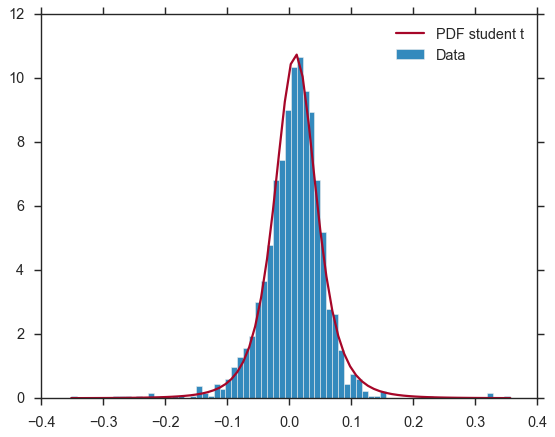

In [199]:
# PLOT: 
plt.figure(num=None, figsize=(8, 6))
plt.hist(mxSP500LogReturn['log returns'],bins='fd',density=True,label='Data')
plt.plot(x_bins,sTPDF,label='PDF student t')
plt.legend()

In [28]:
# Non central Student-t distribution 
nctParameter= stats.nct.fit(mxSP500LogReturn['log returns'])
nctParameter

(3.9001685848114462,
 -0.5770249797710596,
 0.03210325628817566,
 0.03413539247386711)

In [40]:
ncsTPDF = stats.nct.pdf(x_bins,*nctParameter)

In [41]:
ncsTPDF == sTPDF

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [33]:
# Statistical information: 
# First 4 moments - mean(m) , variance (v), skew(s), kurtosis(k) -> 'mvsk'
nctStats = np.array( stats.nct.stats(nctParameter[0],nctParameter[1],nctParameter[2],nctParameter[3],moments='mvsk'))
nctStats

array([ 0.00724297,  0.00256996, -1.62171206,         nan])

In [35]:
stStats

array([0.01039855, 0.00252723, 0.        ,        inf])

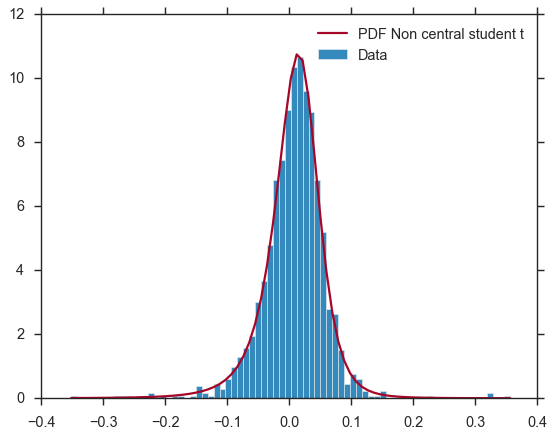

In [211]:
plt.figure(num=None, figsize=(8, 6))
plt.hist(mxSP500LogReturn['log returns'],bins='fd',density=True,label='Data')
plt.plot(x_bins,ncsTPDF,label='PDF Non central student t')
plt.legend()

In [ ]:
# Comparing all Models:

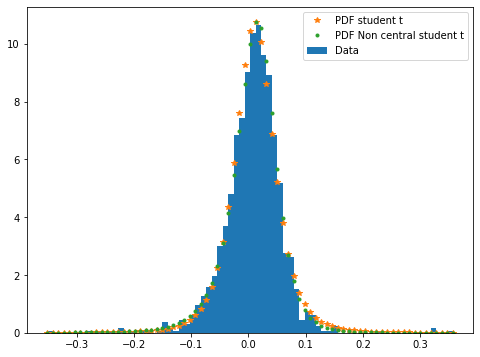

In [42]:
plt.figure(num=None, figsize=(8, 6))
plt.hist(mxSP500LogReturn['log returns'],bins='fd',density=True,label='Data')
#plt.plot(x_bins,NormPDF,label='PDF Norm')
plt.plot(x_bins,sTPDF,'*',label='PDF student t')
plt.plot(x_bins,ncsTPDF,'.',label='PDF Non central student t')
plt.legend()

In [254]:
# Table of summary statistics: 
pd.DataFrame([ObservedStats,NormStats,stStats,nctStats],columns=['mean', 'variance','skew','kurtosis'],index=['Observed','Normal','Student t','Non-central st'])

,mean,variance,skew,kurtosis
Observed,0.007582,0.002589,-0.478152,8.205244
Normal,0.007582,0.002588,0.000000,0.000000
Student t,0.010399,0.002527,0.000000,inf
Non-central st,0.007243,0.002570,-1.621712,NaN


In [ ]:
##################################################################################################################################################################### QUANTILE PLOTS
####################################################################################################################################################################

In [ ]:
stats.probplot(snpLogReturn,dist='norm',plot=plt)


In [ ]:
stats.probplot(snpLogReturn,dist=stats.t(2.9914276198815717, 0.009089830436999109, 0.02693090874311875) ,plot=plt)

Take a look on more sophisticated plots [here](https://matplotlib.org/mpl-probscale/tutorial/closer_look_at_viz.html) .


# **Power Law Models of Extreme Events**

In [14]:
samplesize = 100000

In [15]:
NormSample = stats.norm.rvs(size =samplesize,random_state =1)

In [16]:
CauchySample = stats.cauchy.rvs(size = samplesize,random_state =1)

In [ ]:
plt.plot(NormSample,'.')

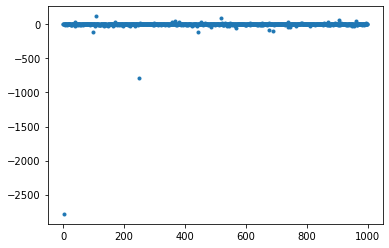

In [66]:
plt.plot(CauchySample,'.')

In [17]:
len(NormSample[abs(NormSample) > 3 ]) /len(NormSample)

0.00288

In [18]:
len(CauchySample[abs(CauchySample) > 3 ])/len(CauchySample)

0.20662

In [ ]:
# For time stamps
from datetime import datetime
from pandas_datareader import data, wb

In [ ]:
# The tech stocks we'll use for this analysis
tech_list = ['AAPL','GOOG','MSFT','AMZN','SNP']

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 1,end.month,end.day)


# #For loop for grabing yahoo finance data and setting as a dataframe
# panel_data = data.DataReader('INPX', 'yahoo', start, end)

for stock in tech_list:   
    # Set DataFrame as the Stock Ticker
    globals()[stock] = data.DataReader(stock,'yahoo',start,end)

In [ ]:
AAPL.describe()

,High,Low,Open,Close,Volume,Adj Close
count,252.000000,252.000000,252.000000,252.000000,2.520000e+02,252.000000
mean,291.861746,284.903413,287.969881,288.781468,3.593084e+07,287.279108
std,56.288910,54.779926,55.463582,55.754593,1.726080e+07,56.197139
min,202.050003,199.149994,199.619995,200.479996,1.165440e+07,198.510406
25%,249.937500,241.662498,247.014996,246.315002,2.439980e+07,244.351742
50%,285.360001,278.679993,281.449997,283.070007,3.119720e+07,281.797729
75%,322.842491,316.692490,319.437500,319.230011,4.167190e+07,318.209122
max,457.649994,441.170013,452.820007,455.609985,1.067212e+08,454.790009


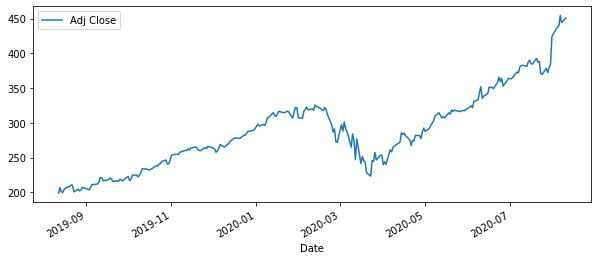

In [ ]:
# Let's see a historical view of the closing price
AAPL['Adj Close'].plot(legend=True,figsize=(10,4))

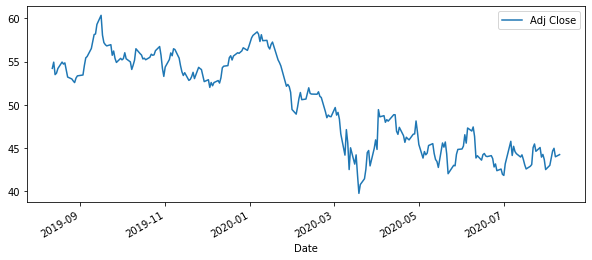

In [ ]:
# Let's see a historical view of the closing price
SNP['Adj Close'].plot(legend=True,figsize=(10,4))

# **Markowitz's Modern Portfolio Theory: Mean-Variance Portfolios**

> Modern Portfolio Theory or MPT is widely used as the basis for constructing portfolios. It assumes that asset returns can be modeled using a multivariate Normal distribution and further assumes that risk is measured by a portfolio's variance (or equivalently standard deviation) of return and reward is measured by a portfolio's expected value of return.\
\
Despite concerns about the reasonableness of these assumptions, MPT provides a framework for selecting portfolios based on a trade-off of risk and reward. MPT leads an investor to allocate capital based on the overall characteristics of the portfolio rather than allocating capital to individual assets on a case-by-case basis without considering how the performance of individual assets may interact.\
\
See http://en.wikipedia.org/wiki/Modern_portfolio_theory.




## **The Markowitz model** ##
### *Portfolio Mean and Variance*
>Portfolio Mean:
$$\mu_P = \mathbf{\mu}^{T}\mathbf{x}.$$
Portfolio Variance:
$$\sigma_P^2 = \mathbf{x}^{T} \mathbf{\Sigma} \mathbf{x}.$$

### *Balacing Risk & Reward*
>Trade-off risk and reward. In what follows the set $\mathcal{S}$ is typically convex and frequently expressed as a system of linear constraints. The general form is the quadratic program:
$$\min\left\{\dfrac{1}{2}\mathbf{x}^T\mathbf{\Sigma}\mathbf{x}-\lambda\mathbf{\mu}^T\mathbf{x} \, | \, \mathbf{x} \in \mathcal{S}\right\}, 0 \leq \lambda \leq +\infty.$$
\
Minimum variance portfolio ($\lambda \rightarrow 0$):
$$\min\left\{\dfrac{1}{2}\mathbf{x}^T\mathbf{\Sigma}\mathbf{x} \, | \, \mathbf{x} \in \mathcal{S}\right\}.$$
\
Maximum return portfolio, which simplifies to a linear program ($\lambda \rightarrow +\infty$):
$$\min\left\{-\mathbf{\mu}^T\mathbf{x} \, | \, \mathbf{x} \in \mathcal{S}\right\}.$$
\
Minimize risk at target rate of return:
$$\min\left\{\dfrac{1}{2}\mathbf{x}^T\mathbf{\Sigma}\mathbf{x} \, | \, \mathbf{\mu}^T\mathbf{x} \geq \tau \wedge \mathbf{x} \in \mathcal{S}\right\}.$$
\
Maximize return at a target level of risk:
$$\max\left\{\mathbf{\mu}^T\mathbf{x} \, | \, \mathbf{x}^T\mathbf{\Sigma}\mathbf{x} = q \wedge \mathbf{x} \in \mathcal{S}\right\}.$$

## **Monte Carlo Simulation**
>Consider the case where the capital is assumed to be equal to 1 (*i.e.*, $\mathbf{x}$ represents proportional allocation) and no short positions are allowed.
$$\mathcal{P}_{\mathrm{Feasible}} = \left\{\left\{\mathbf{x}^T\mathbf{\Sigma}\mathbf{x},\mathbf{\mu}^T\mathbf{x}\right\} \, | \, \mathbf{x}^T\mathbf{1} = 1 \wedge \mathbf{x} \geq \mathbf{0}\right\}.$$
The strategy is to simulate a large number of feasible portfolios and examine their behavior in $\{\sigma^2,\mu\}$-space.\
A covariance matrix can be constructed by specifying the correlation and volatility separately. The strategy for this is based on the following:
$$\sigma_{x,y} = \rho_{x,y}\sigma_x\sigma_y.$$

In [ ]:
vnMean = np.array([0.05, 0.08, 0.10])
vnSigma = np.array([0.07, 0.09, 0.10])
mnCor = np.array([[1, 0.4, 0.6], [0.4, 1, 0.4], [0.6, 0.4, 1]])
mnCov = np.kron(vnSigma,vnSigma).reshape(3,3)*np.array(mnCor)
print("\u03BC = ", np.array(vnMean).reshape(-1,1))
print("\u03C3 = ", np.array(vnSigma).reshape(-1,1))
print("C = ", mnCor)
print("\u03A3 = ", mnCov)

μ =  [[0.05]
 [0.08]
 [0.1 ]]
σ =  [[0.07]
 [0.09]
 [0.1 ]]
C =  [[1.  0.4 0.6]
 [0.4 1.  0.4]
 [0.6 0.4 1. ]]
Σ =  [[0.0049  0.00252 0.0042 ]
 [0.00252 0.0081  0.0036 ]
 [0.0042  0.0036  0.01   ]]


>In generating random feasible portfolios, we will assume that short positions are not permitted, *i.e.*, $x_i \geq 0$. The simulation will produce 10,000 cases for analysis.\
\
A straightforward way to sample from the set of feasible portfolios is:

[0.787604105830718, 0.754458093233921]
[0.510747300795293, 0.4892526992047071]


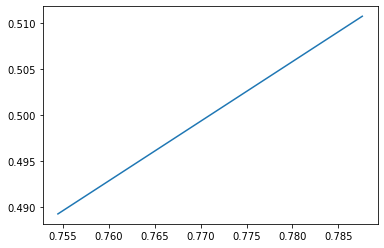

In [ ]:

list1 = np.random.uniform(0,1,2).tolist()
list2 = [i/sum(list1) for i in list1]
print(list1)
print(list2)
plt.plot(list1,list2)
plt.show()

In [ ]:
NumberOfAssets = len(vnMean)
NumberOfSamples = 100000

def NormalizedList(n):
  # returns a list of n  normalized numbers generated from a normal distribution 
  # This are the weights for the portifolio 
  List1= np.random.uniform(0,1,n)
  NormalizedList= [i/sum(List1) for i in List1]
  return NormalizedList

def xRandomPortfolio(nAssets,nSample):
  # Here, we generate -nSamples-  of portifolio weights given by NormalizedList
  return np.array([NormalizedList(nAssets) for i in range(nSample)])

def xPortSdevMean(PortWeight,AssetsMean,AssetsSigma):
  # The mean of the portifolio.  
  # Mean.x:
  PortMean = AssetsMean.dot(PortWeight.transpose())
  # Standart deviation for the portifolio
  # sqrt (x.CovarianceMatrix.x) :
  PortStandDev=np.sqrt(PortWeight.dot(PortWeight.dot(AssetsSigma).transpose()))

  return [PortMean, PortStandDev]

def EffiPortFilter(data):
  #Sort the np array data by the standart deviation columm 
  DataSort =  data[np.argsort(data[:,1])]
    #  np.argsort(data[:,1])
    # Select the portifolio -i- only if it has a return -i[0]-
    # bigger than it's priviews
  lis =[]
  lis.append(DataSort[0])
  for i in DataSort:
    if i[0] > lis[len(lis) -1][0]:
      lis.append(i)
  return np.array(lis)

# Maybe change the fucntion to get just one Weight at the time.
# This function return a list of all the weights in for the Pareto optimal portifolio.
def EffiPortWeights(Portlist, EffPortlist,WeightList):

  filter = [ (Portlist[:,0]==Element[0]) & (Portlist[:,1]==Element[1]) for Element in EffPortlist ]
  return [ WeightList[i] for i in filter];


Generates -NumberOfSamples- of portifolio weights:

In [ ]:
x = xRandomPortfolio(3,NumberOfSamples)

In [ ]:
x[0]

array([0.15674603, 0.48460358, 0.35865038])

Computes the pair (Portifolion Mean, Portifolio Std ) for each portifolio generated 

In [ ]:
PortList=np.array([xPortSdevMean(i,vnMean,mnCov) for i in x ])

In [ ]:
PortList

array([[0.08247063, 0.07358901],
       [0.08295356, 0.07371667],
       [0.08037895, 0.07206819],
       ...,
       [0.07662661, 0.07153103],
       [0.08659931, 0.07777987],
       [0.06542784, 0.06837491]])

Select the pareto optimal portifolio

In [ ]:
EffiPortList= EffiPortFilter(PortList)

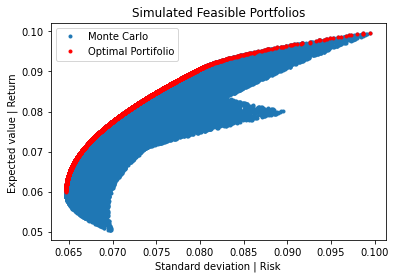

In [ ]:
plt.plot(PortList[:,1],PortList[:,0],'.',label='Monte Carlo')
plt.plot(EffiPortList[:,1],EffiPortList[:,0],'r.',label='Optimal Portifolio')
plt.ylabel('Expected value | Return ')
plt.xlabel('Standard deviation | Risk')
plt.title('Simulated Feasible Portfolios')
plt.legend()

In [ ]:
WeightListEffi = EffiPortWeights(PortList,EffiPortList,x)

In [ ]:
WeightListEffi[1]

array([[0.67787379, 0.2920587 , 0.03006751]])

# Analytical Solution 


In [ ]:
def xOptimalPortfolio(PortCovar,PortMean,L):

  InverseCovar = np.linalg.inv(PortCovar)
 # InverseCovar.sum() return the sum of all elements = 1T.M.1 
  LagrangeMulti = (1 - L*InverseCovar.dot(PortMean).sum())/ InverseCovar.sum()
  return L* InverseCovar.dot(PortMean) + LagrangeMulti*InverseCovar.dot([1,1,1])


In [ ]:
xOptimalPortfolio(mnCov,vnMean,0.03)

array([0.40134564, 0.35831638, 0.24033798])

In [ ]:
np.linalg.inv(mnCov).dot([1,1,1])

array([162.45039683,  69.99559083,   6.57242063])

In [ ]:
np.linalg.inv(mnCov).dot([1,1,1])

array([162.45039683,  69.99559083,   6.57242063])

In [ ]:
xEffi=[xOptimalPortfolio(mnCov,vnMean,i) for i in np.arange(0,0.1,0.01)]

In [ ]:
PortEffiAnaly=np.array([xPortSdevMean(i,vnMean,mnCov) for i in xEffi])

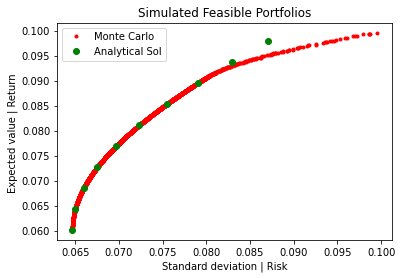

In [ ]:
#plt.plot(PortList[:,1],PortList[:,0],'.')
plt.plot(EffiPortList[:,1],EffiPortList[:,0],'r.',label='Monte Carlo')
plt.plot(PortEffiAnaly[:,1],PortEffiAnaly[:,0],'go',label='Analytical Sol')
plt.ylabel('Expected value | Return ',)
plt.xlabel('Standard deviation | Risk')
plt.title('Simulated Feasible Portfolios')
plt.legend()

#A Look at Real Data

Reading  Ficancial data from Yahoo: 

In [ ]:
# For time stamps
from datetime import datetime
from pandas_datareader import data, wb

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(1927,12,29)

# We are going to consider S&P 500 index for this analysis
#snpData = data.DataReader(['sp500'],'fred',start,end)

# We are going to consider S&P 500 index for this analysis
snpData = data.DataReader('^GSPC','yahoo',start,end)


snpData.describe()

,High,Low,Open,Close,Volume,Adj Close
count,23271.000000,23271.000000,23271.000000,23271.000000,2.327100e+04,23271.000000
mean,483.124418,477.299496,480.303690,480.406829,7.614022e+08,480.406829
std,717.569833,709.603806,713.762413,713.880951,1.477262e+09,713.880951
min,4.400000,4.400000,4.400000,4.400000,0.000000e+00,4.400000
25%,23.799999,23.799999,23.799999,23.799999,1.265000e+06,23.799999
50%,100.139999,98.599998,99.339996,99.360001,1.714000e+07,99.360001
75%,828.990021,807.110016,817.065002,816.829987,5.201950e+08,816.829987
max,3399.959961,3379.310059,3392.510010,3398.610107,1.145623e+10,3398.610107


In [ ]:
snpData['Adj Close']

Date
1927-12-30      17.660000
1928-01-03      17.760000
1928-01-04      17.719999
1928-01-05      17.549999
1928-01-06      17.660000
                 ...     
2020-08-17    3381.989990
2020-08-18    3389.780029
2020-08-19    3374.850098
2020-08-20    3385.510010
2020-08-21    3398.610107
Name: Adj Close, Length: 23271, dtype: float64

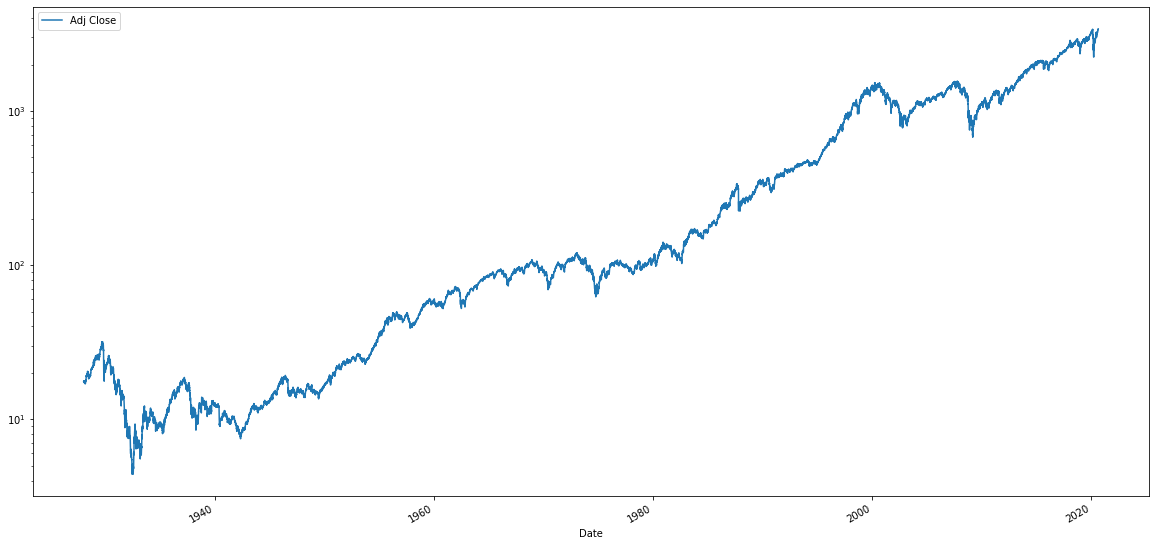

In [ ]:
snpData['Adj Close'].plot(legend=True,figsize=(20,10))
plt.yscale('log')

In [ ]:
snpData['LogReturn']=np.log(snpData['Adj Close'])-np.log(snpData['Adj Close'].shift(1))

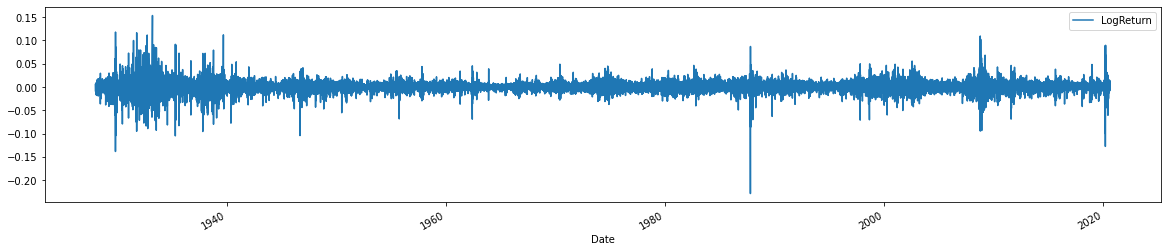

In [ ]:
snpData['LogReturn'].plot(legend=True,figsize=(20,4))

##Exploratory Data Analysis: Local Volatility

In [ ]:
np.mean(snpData['LogReturn'])**2

5.10915336753884e-08

In [ ]:
np.std(snpData['LogReturn'])

0.012017307563555544

In [ ]:
np.mean(snpData['LogReturn']**2)

0.00014446677261076432

In [ ]:
np.sqrt(np.mean(snpData['LogReturn']**2) -np.mean(snpData['LogReturn'])**2)

0.01201730756355553

In [ ]:
np.sqrt(np.mean(snpData['LogReturn']**2))

0.012019433123519774

In [ ]:
np.mean(snpData['LogReturn'])

0.00022603436392590486

In [ ]:
NormalSNP = np.random.normal(np.mean(snpData['LogReturn']),np.std(snpData['LogReturn']))

In [ ]:
SampleSNP = np.array([NormalSNP**2 for i in range(1000) ]).cumsum() ;

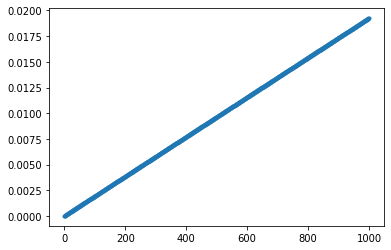

In [ ]:
plt.plot(range(1000),SampleSNP,'.')

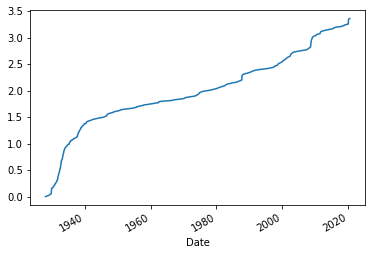

In [ ]:
((snpData['LogReturn'][1:]**2).cumsum()).plot()

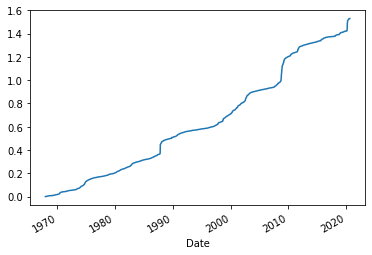

In [ ]:
((snpData['LogReturn'][10000:]**2).cumsum()).plot()

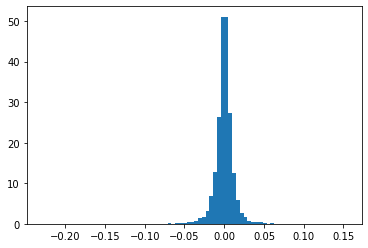

In [ ]:
_, bins, _ = plt.hist(snpData['LogReturn'][1:],bins=80,density=True,)

In [ ]:
bins

array([-0.22899729, -0.22421405, -0.21943082, -0.21464759, -0.20986436,
       -0.20508113, -0.20029789, -0.19551466, -0.19073143, -0.1859482 ,
       -0.18116496, -0.17638173, -0.1715985 , -0.16681527, -0.16203204,
       -0.1572488 , -0.15246557, -0.14768234, -0.14289911, -0.13811587,
       -0.13333264, -0.12854941, -0.12376618, -0.11898295, -0.11419971,
       -0.10941648, -0.10463325, -0.09985002, -0.09506678, -0.09028355,
       -0.08550032, -0.08071709, -0.07593386, -0.07115062, -0.06636739,
       -0.06158416, -0.05680093, -0.0520177 , -0.04723446, -0.04245123,
       -0.037668  , -0.03288477, -0.02810153, -0.0233183 , -0.01853507,
       -0.01375184, -0.00896861, -0.00418537,  0.00059786,  0.00538109,
        0.01016432,  0.01494756,  0.01973079,  0.02451402,  0.02929725,
        0.03408048,  0.03886372,  0.04364695,  0.04843018,  0.05321341,
        0.05799665,  0.06277988,  0.06756311,  0.07234634,  0.07712957,
        0.08191281,  0.08669604,  0.09147927,  0.0962625 ,  0.10

Fit a normal distribution:


x = Bins 
y = NormalPDF(x,mean, std)  

In [ ]:
mu, sigma = stats.norm.fit(snpData['LogReturn'][1:])
best_fit_line = stats.norm.pdf(bins, mu, sigma)

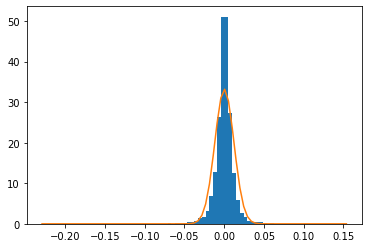

In [ ]:
_, bins, _= plt.hist(snpData['LogReturn'][1:],density=True,bins=80)
plt.plot(bins, best_fit_line)

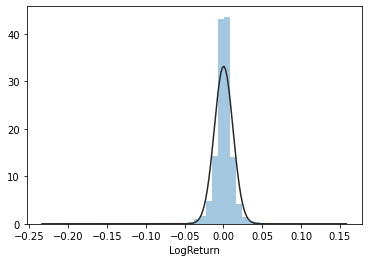

In [ ]:
sns.distplot(snpData['LogReturn'][1:], fit=stats.norm, kde=False)

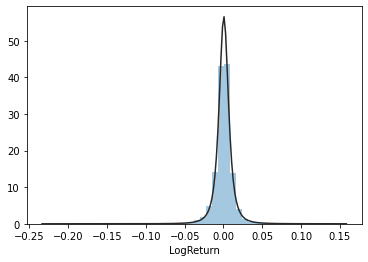

In [ ]:
sns.distplot(snpData['LogReturn'][1:], fit=stats.t, kde=False)

In [ ]:
Tfit =stats.t.fit(snpData['LogReturn'][1:])

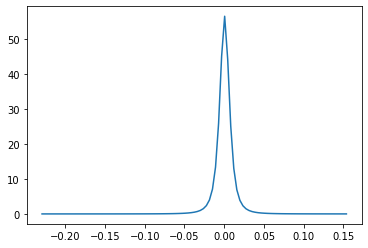

In [ ]:
plt.plot(bins,stats.t.pdf(bins,Tfit[0],Tfit[1],Tfit[2]));